In [3]:
import pandas as pd
import pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import community
import community.community_louvain as community_louvain
import networkx as nx
import random
import collections
import csv
import seaborn as sns

In [10]:
def data_graph(dataset, delimiter):
    
    data = pd.read_csv(dataset, delimiter=delimiter)
    print(data.shape)
    data.columns = ['From','To']
    tempWeight = [1 for i in range(data.shape[0])]
    data['Weight'] = tempWeight
    print(data.head())
    
    graph = nx.Graph()
    # Adding the edges.
    for index,row in data.iterrows():
        graph.add_edges_from([(row[0],row[1])],weight = row[2])
    
    return data, graph

In [11]:
cancer1_csv, cancer1_graph = data_graph('../data/Bone-Cancer.csv',",")

(1783, 2)
          From      To  Weight
0        4EBP1    AKT1       1
1        4EBP1   CCND1       1
2        4EBP1  MAPK14       1
3        4EBP1   TFDP1       1
4  14-3-3-zeta    AKT1       1


In [14]:
def transitivity(data, skip):
    pos = data.loc[data['Weight'] > 0]
    neg = data.loc[data['Weight'] < 0]
    graphP = nx.Graph()
    # Adding the edges.
    for index,row in pos.iterrows():
        graphP.add_edges_from([(row[0],row[1])])
    print('+ve Transitivity: ' + str(nx.transitivity(graphP)))
    if not skip:
        graphN = nx.DiGraph()
        # Adding the edges.
        for index,row in neg.iterrows():
            graphN.add_edges_from([(row[0],row[1])])
        print('-ve Transitivity: ' + str(nx.transitivity(graphN)))

In [15]:
transitivity(cancer1_csv, True)

+ve Transitivity: 0.2619917012448133


In [27]:
def stats(data,graph):
    # Number of nodes
    print('Nodes = ' + str(graph.number_of_nodes()))

    # Number of edges
    print('Edges = ' + str(graph.number_of_edges()))

    # Positive and negative edges 

    Stats = pd.DataFrame(graph.degree(),columns=['From','Degree']).sort_values('From')
    b= data.groupby('From',as_index=False)[['Weight']].sum().sort_values('From')
    c= data.groupby('To',as_index=False)[['Weight']].sum().sort_values('To')
    Stats = Stats.merge(b,on='From',how='left')
    Stats = Stats.drop(['Weight'],axis=1)
    Stats.fillna(0,inplace=True)
    print(Stats.head())
    
    print(Stats.describe())
    print(Stats.max(axis=0))
    
    print('Average Clustering = ' + str(nx.average_clustering(graph)))
    print('Transitivity = '+ str(nx.transitivity(graph)))
    print('Density = ' + str(nx.density(graph)))
    
    data['Weight'].plot.hist(bins=2, alpha=1, align='mid')
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.title('Count of weight of edges')
    plt.xticks([-1,1])
    plt.show()
    
    return Stats

Nodes = 351
Edges = 1783
          From  Degree
0  14-3-3-zeta       7
1        4EBP1       4
2        ABIN2       9
3         ABL1      38
4         AIP4       7
           Degree
count  351.000000
mean    10.159544
std     10.641840
min      1.000000
25%      3.000000
50%      7.000000
75%     12.000000
max     66.000000
From      add1
Degree      66
dtype: object
Average Clustering = 0.22900659944437912
Transitivity = 0.2619917012448133
Density = 0.02902726902726903


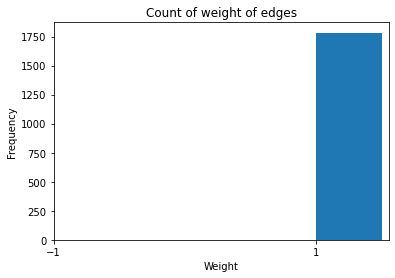

In [28]:
cancer1_Stats = stats(cancer1_csv, cancer1_graph)

In [29]:
cancer1_Stats

,From,Degree
0,14-3-3-zeta,7
1,4EBP1,4
2,ABIN2,9
3,ABL1,38
4,AIP4,7
...,...,...
346,YY1,3
347,ZIN,3
348,ZNF216,2
349,ZNF259,2


In [41]:
def degreeDistribution(data,graph):
    
    degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    #print(degreeCount)
    deg, cnt = zip(*degreeCount.items())
    #deg, cnt = np.array(deg), deg.array(cnt)
#     print(len(deg))
#     deg = deg[0:100]
#     cnt = cnt[0:100]
#     print(len(deg))
    print()
    plt.figure(figsize=(15, 5), dpi=80)
    plt.plot(deg,cnt,color="#3F5D7D")
    plt.xlabel('Degree /Number of Connections')
    plt.ylabel('Number of nodes')
    plt.title('Actual Plot(Epinion)')
    plt.grid()
    plt.xlim([0, max(deg)])
    plt.show()
    print()
    plt.figure(figsize=(15, 5), dpi=80)
    plt.bar(deg,(np.log(cnt)),color = 'r')
    #plt.plot(n1)
    #plt.plot(deg,(np.log(cnt)),color="#3F5D7D")
    plt.xlabel('In-Degree /Number of Connections')
    plt.ylabel('Number of nodes')
    plt.title('Log Plot(Epinion)')
    plt.xlim([0, max(deg)])
    plt.grid()
    plt.show()
    

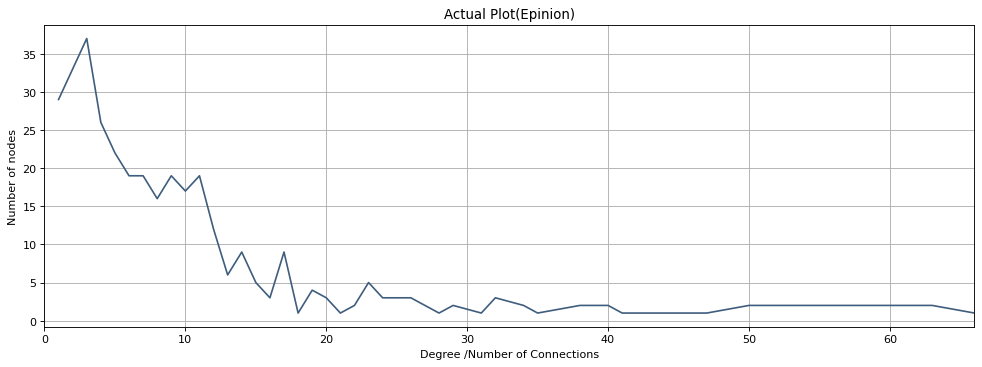

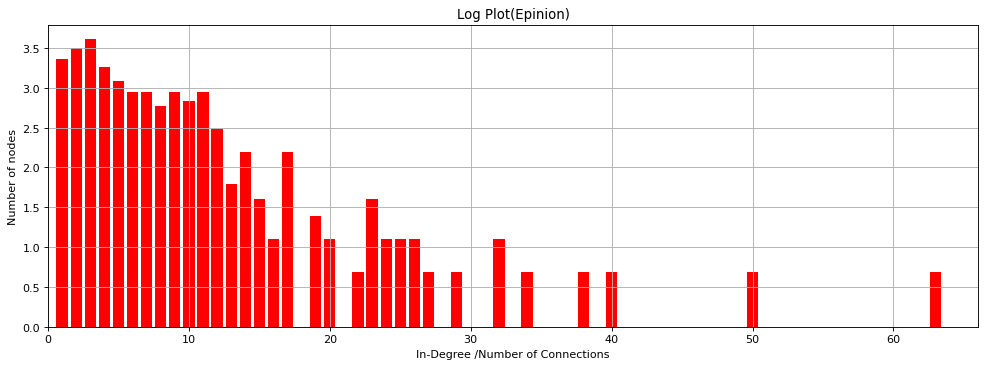

In [42]:
degreeDistribution(cancer1_csv, cancer1_graph)

In [43]:
def degreeCentrality(graph, name):
    # Degree centrality stats
    print("Degree")
    degree_centrality_nodes = nx.degree_centrality(graph)
    degree_centrality_nodes = collections.Counter(degree_centrality_nodes)
    for k, v in degree_centrality_nodes.most_common(10):
        print ((k, v))
    with open(name+'_degreecentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in degree_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count))  
    DegreeCentrality = pd.read_csv(name+'_degreecentrality.csv', delimiter=',')
    
    return DegreeCentrality

In [55]:
def H_value(max_value,in_values):
  sum = np.sum(max_value - np.array(in_values))
  return sum

# Sample modified degree centrality
# According to the proposed approach the node with least
# degree centrality (as H value will be high for the most
# influential node and it is in the denominator) can be
# considered as the node with most number of connections and
# hence the most influential node.

# G = nx.gn_graph(10)
# G = nx.petersen_graph()
# subax2 = plt.subplot(121)
# nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

def enhancedCentrality(graph, name):
  A = nx.adjacency_matrix(graph)
  B = A.astype(np.bool_)
  C = B.toarray()

  degree_centrality_nodes = nx.degree_centrality(graph)
  
  values = list(degree_centrality_nodes.values())
  values = [i*(len(values)-1) for i in values]
  max_value = max(values)
  sum = H_value(max_value,values)
  print(sum)
  clustering_array = nx.clustering(graph)
  clustering_values = list(clustering_array.values())
  clustering_values = [float(i) for i in clustering_values]
  with open(name+'_clusteringCentrality.csv', encoding='utf-8-sig', mode='w') as fp:
    fp.write('col1\n')
    for val in clustering_values:  
      fp.write('{}\n'.format(val))

  enhanced_degree_centrality = []
  if name == 'Epinion':
    for i in range(len(C)):
      #temp = (float(max_value - in_degree_centrality_nodes[i])) * float(clustering_array[i]) /float(sum) 
      temp = (float(max_value - degree_centrality_nodes[i])) 
      enhanced_degree_centrality.append((i,temp))
  else:
    for i,j in degree_centrality_nodes:
      temp = (float(max_value - j)) * float(clustering_array[i]) /float(sum) 
      enhanced_degree_centrality.append((i,temp))
    
  enhanced_degree_centrality = [ (i,'%.12f' % elem) for i,elem in enhanced_degree_centrality ]
  # print(enhanced_degree_centrality)
  file = open(name+'______enhancedDegreeCentrality.csv', 'w+', newline ='\n') 
  with file:     
    write = csv.writer(file) 
    write.writerows(enhanced_degree_centrality) 
    
  enhancedInDegreeCentrality = pd.read_csv(name+'_enhancedDegreeCentrality.csv', delimiter=',')
  clusteringCentrality = pd.read_csv(name+'_clusteringCentrality.csv', delimiter=',')
    
  return enhancedDegreeCentrality, clusteringCentrality




# def H_value(max_value,in_values):
#   sum = np.sum(max_value - np.array(in_values))
#   return sum

# # Sample modified degree centrality
# # According to the proposed approach the node with least
# # degree centrality (as H value will be high for the most
# # influential node and it is in the denominator) can be
# # considered as the node with most number of connections and
# # hence the most influential node.

# # G = nx.gn_graph(10)
# # G = nx.petersen_graph()
# # subax2 = plt.subplot(121)
# # nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

# def enhancedCentrality(graph, name):
#   A = nx.adjacency_matrix(graph)
#   B = A.astype(np.bool_)
#   C = B.toarray()
#   in_degree_centrality_nodes = nx.in_degree_centrality(graph)
#   in_values = list(in_degree_centrality_nodes.values())
#   in_values = [i*(len(in_values)-1) for i in in_values]
#   max_value = max(in_values)
#   sum = H_value(max_value,in_values)
#   clustering_array = nx.clustering(graph)
#   clustering_values = list(clustering_array.values())
#   clustering_values = [float(i) for i in clustering_values]
#   with open(name+'_clusteringCentrality.csv', encoding='utf-8-sig', mode='w') as fp:
#     fp.write('col1\n')  
#     for val in clustering_values:  
#       fp.write('{}\n'.format(val)) 

#   enhanced_degree_centrality = []
#   for i in range(len(C)):
#     temp = (float(max_value - in_values[i])) * float(clustering_values[i]) /float(sum) 
#     enhanced_degree_centrality.append(temp)
    
#   enhanced_degree_centrality = [float(i) for i in enhanced_degree_centrality]
#   with open(name+'_enhancedInDegreeCentrality.csv', encoding='utf-8-sig', mode='w') as fp:
#     fp.write('col1\n')  
#     for val in enhanced_degree_centrality:  
#       fp.write('{}\n'.format(val)) 
    
#   enhancedInDegreeCentrality = pd.read_csv(name+'_enhancedInDegreeCentrality.csv', delimiter=',')
#   clusteringCentrality = pd.read_csv(name+'_clusteringCentrality.csv', delimiter=',')
    
#   return enhancedInDegreeCentrality, clusteringCentrality

In [45]:
def eigenVectorCentrality(graph, name):
    # Eigen Vector centrality stats
    print("Eigen Vector centrality")
    eigenvector_centrality_nodes = nx.eigenvector_centrality_numpy(graph)
    eigenvector_centrality_nodes = collections.Counter(eigenvector_centrality_nodes)
    for k, v in eigenvector_centrality_nodes.most_common(10):
        print ((k, v))
    with open(name+'_eigenvectorcentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in eigenvector_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
            
    eigenvectorCentrality = pd.read_csv(name+'_eigenvectorcentrality.csv', delimiter=',')

    return eigenvectorCentrality


In [46]:
def khatzCentrality(graph,name):
    # Katz centrality stats
    # Not running on colab
    print("Katz centrality")
    katz_centrality_numpy_nodes = nx.katz_centrality_numpy(graph)
    katz_centrality_numpy_nodes = collections.Counter(katz_centrality_numpy_nodes)
#    for k, v in katz_centrality_numpy_nodes.most_common(10):
#      print ((k, v))
    with open(name+'_khatzcentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in katz_centrality_numpy_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
            
    khatzCentrality = pd.read_csv(name+'_khatzcentrality.csv', delimiter=',')

    return khatzCentrality

In [47]:
def closenessCentrality(graph, name):
    # Closeness centrality stats
    # Not running on colab
    print("closeness centrality ")
    closeness_centrality_nodes = nx.closeness_centrality(graph)
    closeness_centrality_nodes = collections.Counter(closeness_centrality_nodes)
#    for k, v in closeness_centrality_nodes.most_common(10):
#        print ((k, v))
    with open(name+'_closenesscentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in closeness_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
            
    closenessCentrality = pd.read_csv(name+'_closenesscentrality.csv', delimiter=',')

    return closenessCentrality

In [48]:
def betweenessCentrality(graph,name):
    # Betweenness centrality stats
    # Not running on colab
    print("Betweenness centrality ")
    betweenness_centrality_nodes = nx.betweenness_centrality(graph)
    betweenness_centrality_nodes = collections.Counter(betweenness_centrality_nodes)
#    for k, v in betweenness_centrality_nodes.most_common(10):
#        print ((k, v))
    with open(name+'_betweennessscentrality.csv', encoding='utf-8-sig', mode='w') as fp:
        fp.write('col1,col2\n')  
        for tag, count in betweenness_centrality_nodes.items():  
            fp.write('{},{}\n'.format(tag, count)) 
            
    betweennessCentrality = pd.read_csv(name+'_betweennessscentrality.csv', delimiter=',')

    return betweennessCentrality

In [57]:
def degreeRelationship(Stats, graph, name):
    # Out degree and indegree relationship, relationship between positive and negative weighted outgoing 
    # edges in the network and relationship between positive and negative ingoing edges.
    
#     plt.figure(figsize=(5, 5), dpi=80)
#     plt.plot(Stats['Pos_out'],Stats['Neg_out'],'o',markersize=0.4, color = 'brown')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('Positive Outdegree')
#     plt.ylabel('Negativetive Outdegree')
#     plt.title(name+' Outdegree(Pos-Neg) relationship')
#     plt.legend(['Node'])
#     plt.grid()
#     plt.show()
    
#     plt.figure(figsize=(5, 5), dpi=80)
#     plt.plot(Stats['Pos_in'],Stats['Neg_in'],'o',markersize=0.4, color = 'brown')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('Positive Indegree')
#     plt.ylabel('Negativetive Indegree')
#     plt.title(name+' Indegree(Pos-Neg) relationship')
#     plt.legend(['Node'])
#     plt.grid()
#     plt.show()
    
#     plt.figure(figsize=(5, 5), dpi=80)
#     plt.plot(Stats['Outdegree'],Stats['Indegree'],'o',markersize=0.4, color = 'brown')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('Outdegree')
#     plt.ylabel('Indegree')
#     plt.title(name+' Outdegree-Indegree relationship')
#     plt.legend(['Node'])
#     plt.grid()
#     plt.show()
    
    
    plt.figure(figsize=(5, 5), dpi=80)
    Deg_cor = nx.average_neighbor_degree(graph)
    dict_list = []
    for key, value in Deg_cor.items():
        temp = [key,value]
        temp[0] = graph.degree(key)
        dict_list.append(temp)
    dfa11 = pd.DataFrame(dict_list,columns =['Degree','Average neighbors Degree'])
    dfa21 = dfa11.groupby('Degree',as_index=False)['Average neighbors Degree'].mean()
    plt.plot(dfa11['Degree'],dfa11['Average neighbors degree'],'o',markersize=0.3, color = 'brown')
    plt.plot(dfa21['Degree'],dfa21['Average neighbors ddegree'],'o',markersize=1, color = 'yellow')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Degree')
    plt.ylabel('Average neighbors degree')
    plt.title(name+' Degree-Neighbour degree relationship')
    plt.legend(['Node','Mean at same degree'])
    plt.grid()
    plt.show()
    
    
#     plt.figure(figsize=(5, 5), dpi=80)
#     Deg_cor = nx.average_neighbor_degree(graph,target='in')
#     dict_list = []
#     for key, value in Deg_cor.items():
#         temp = [key,value]
#         temp[0] = graph.degree(key,'in')
#         dict_list.append(temp)
#     dfa12 = pd.DataFrame(dict_list,columns =['Indegree','Average neighbors indegree'])
#     # group same indegree values and take their mean
#     dfa22 = dfa12.groupby('Indegree',as_index=False)['Average neighbors indegree'].mean()
#     plt.plot(dfa12['Indegree'],dfa12['Average neighbors indegree'],'o',markersize=0.3, color = 'brown')
#     plt.plot(dfa22['Indegree'],dfa22['Average neighbors indegree'],'o',markersize=1, color = 'yellow')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('Indegree')
#     plt.ylabel('Average neighbors indegree')
#     plt.title(name+' Indegree-Neighbour indegree relationship')
#     plt.legend(['Node','Mean at same indegree'])
#     plt.grid()
#     plt.show()
    
#     plt.figure(figsize=(5, 5), dpi=80)
#     plt.plot(dfa12['Indegree'],dfa11['Average neighbors outdegree'],'o',markersize=0.3, color = 'brown')
#     plt.plot(dfa22['Indegree'],dfa21['Average neighbors outdegree'],'o',markersize=1, color = 'yellow')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('Indegree')
#     plt.ylabel('Average neighbors outdegree')
#     plt.title(name+' Indegree-Neighbour outdegree relationship')
#     plt.legend(['Node','Mean at same indegree'])
#     plt.grid()
#     plt.show()
    
#     plt.figure(figsize=(5, 5), dpi=80)
#     plt.plot(dfa11['Outdegree'],dfa12['Average neighbors indegree'],'o',markersize=0.3, color = 'brown')
#     plt.plot(dfa21['Outdegree'],dfa22['Average neighbors indegree'],'o',markersize=1, color = 'yellow')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('Outdegree')
#     plt.ylabel('Average neighbors indegree')
#     plt.title(name+' Outdegree-Neighbour indegree relationship')
#     plt.legend(['Node','Mean at same outdegree'])
#     plt.grid()
#     plt.show()
    
    
    
#     print('In-In assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph,'in','in')))
#     print('Out-Out assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph,'out','out')))
#     print('In-Out assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph,'in','out')))
#     print('Out-In assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph,'out','in')))
    print('Graph assortativity coefficient = '+ str(nx.degree_assortativity_coefficient(graph)))
    

In [58]:
def weakConnected(graph):
    weak = nx.weakly_connected_components(graph)
    weak_list = [c for c in sorted(weak,key=len, reverse=True)]
    weak_nodes = weak_list[0]
    weak_graph = graph.subgraph(weak_nodes)
    return weak_graph

In [60]:
def powerLaw(Stats, graph):
    import math
    pos = Stats['Degree'][Stats['Degree'] != 0]
    pos = pos.transform(lambda x: math.floor(math.log(x)) )

    prob = pos.value_counts(normalize=True)
    threshold = 0.0001
    mask = prob > threshold
    tail_prob = prob.loc[~mask].sum()
    prob = prob.loc[mask]
    prob['other'] = tail_prob
    prob.plot(kind='bar',log=True,color='r')
    plt.title('Degree')
    plt.grid()
    
    import igraph
    pos = Stats['Degree'][Stats['Degree'] != 0]
    print(igraph.power_law_fit(pos))

In [ ]:
def communities(graph):
    SCC = max(nx.strongly_connected_components(graph), key=len)
    print('Size of maximal strongly connected component is ' + str(len(SCC)))
    WCC = max(nx.weakly_connected_components(graph), key=len)
    print('Size of maximal weakly connected component is ' + str(len(WCC)))
    DIF = list(set(WCC)-set(SCC))
    OUT_C = []
    IN_C = []
    IN = 0
    OUT = 0
    for index, node1 in enumerate(DIF):
        for index2, node2 in enumerate(SCC):

            if graph.has_edge(node1,node2):
                OUT+=1
                OUT_C.append(node2)
                break
            elif graph.has_edge(node2,node1):
                IN+=1
                IN_C.append(node1)
                break


    TND = len(DIF)-IN-OUT
    print(IN,OUT,TND)
    
    SCC = max(nx.strongly_connected_components(graph), key=len)
    scc_com = graph.subgraph(SCC).copy()
    scc2 = nx.Graph(scc_com)

    # Removing the weights.

    for u,v,d in scc2.edges(data=True):
        d['weight']=1

    communities =community_louvain.best_partition(scc2,random_state=5)
    
    print(set(communities.values()))
    # node numver, community it belongs to
    # find size of all communities
    # group by val -> key.sum()
    
    ind_graph = community_louvain.induced_graph(communities, scc2)

    inv_map = dict()
    for key, value in communities.items():
        inv_map.setdefault(value, list()).append(key)

    # Removing the small communities

    inv_map2 = {key:val for key, val in inv_map.items() if len(val) >= 100}
    sizes = np.array([len(inv_map2[k]) for k in list(inv_map2.keys())])

    # Removing edges from the graph:

    inv_keys = [key for key in inv_map2]
    ind_nodes = list(ind_graph.nodes())
    for node in ind_nodes:
        if node not in inv_keys:
            ind_graph.remove_node(node)
            
    print(community_louvain.modularity(communities,scc2))
    print(sizes)

In [27]:
def richClubEffect(Stats, graph):
    
    # We want to see the rich club effect in the 100 edges with the highest indegree.
    picked = 100
    rce1 = Stats[['From','Indegree']].sort_values(by=['Indegree'], ascending=False)[0:picked]
    rich = list(rce1.From.values)
    rece_graph = graph.subgraph(rich).copy()
    # Dropping first value

    densities = np.zeros((3,picked))
    pos_edges = 0
    neg_edges = 0 
    for rank, node1 in enumerate(rich[1::]):

        for rank2, node2 in enumerate(rich[:rank+1]): 
            if graph.has_edge(node1, node2):
                if graph[node1][node2]['weight'] == 1:
                    pos_edges += 1
                else:
                    neg_edges += 1
            if graph.has_edge(node2, node1):
                if graph[node2][node1]['weight'] == 1:
                    pos_edges += 1
                else:
                    neg_edges += 1

        densities[0][rank] = pos_edges/(rank+2)/(rank+1)
        densities[1][rank] = neg_edges/(rank+2)/(rank+1)
        densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)

    plt.figure(figsize=(15, 5), dpi=80)
    plt.plot( [i for i in range(0,picked)],densities[0,],'r-',label='Positive edge density(+ve effect)')
    plt.plot( [i for i in range(0,picked)],densities[1,],'b-',label='Negative edge density(+ve effect)')
    #plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
    #plt.legend(loc="upper right")
    #plt.ylim((0,1))
    #plt.xlim((-2,picked-2))
    #plt.show()

    # Checking the one sidedness
    print(nx.reciprocity(rece_graph))
    
    
    
    # We want to see the rich club effect in the 100 edges with the highest negative_degree.
    picked = 100
    rce2 = Stats[['From','Neg_in']].sort_values(by=['Neg_in'], ascending=False)[4:picked+4]
    rich = list(rce2.From.values)
    rece_graph2 = graph.subgraph(rich).copy()
    # Dropping first value

    densities = np.zeros((3,picked))
    pos_edges = 0
    neg_edges = 0 

    for rank, node1 in enumerate(rich[1::]):

        for rank2, node2 in enumerate(rich[:rank+1]): 
            if graph.has_edge(node1, node2):
                if graph[node1][node2]['weight'] == 1:
                    pos_edges += 1
                else:
                    neg_edges += 1
            if graph.has_edge(node2, node1):
                if graph[node2][node1]['weight'] == 1:
                    pos_edges += 1
                else:
                    neg_edges += 1


        densities[0][rank] = pos_edges/(rank+2)/(rank+1)
        densities[1][rank] = neg_edges/(rank+2)/(rank+1)
        densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)


    plt.plot( [i for i in range(0,picked)],densities[0,],'g-',label='Positive edge density(-ve effect)')
    plt.plot( [i for i in range(0,picked)],densities[1,],'m-',label='Negative edge density(-ve effect)')
    #plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
    plt.legend(loc="upper right")
    plt.ylim((0,1))
    plt.xlim((-2,picked-2))
    plt.title('Rich Club Effect', fontsize = 20)
    plt.grid()
    plt.ylim([0,0.6])
    plt.xlabel('Node Number')
    plt.ylabel('Density')
    plt.show()
    
    # Checking the one sidedness
    print(nx.reciprocity(rece_graph2))
    
    
    
#     # We want to see the rich club effect in the 100 edges with the highest outdegree.
#     picked = 100
#     rce3 = Stats[['From','Outdegree']].sort_values(by=['Outdegree'], ascending=False)[0:picked]
#     rich = list(rce3.From.values)
#     rece_graph3 = graph.subgraph(rich).copy()
#     # Dropping first value

#     densities = np.zeros((3,picked))
#     pos_edges = 0
#     neg_edges = 0 
#     for rank, node1 in enumerate(rich[1::]):

#         for rank2, node2 in enumerate(rich[:rank+1]): 
#             if graph.has_edge(node1, node2):
#                 if graph[node1][node2]['weight'] == 1:
#                     pos_edges += 1
#                 else:
#                     neg_edges += 1
#             if graph.has_edge(node2, node1):
#                 if graph[node2][node1]['weight'] == 1:
#                     pos_edges += 1
#                 else:
#                     neg_edges += 1

#         densities[0][rank] = pos_edges/(rank+2)/(rank+1)
#         densities[1][rank] = neg_edges/(rank+2)/(rank+1)
#         densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)


#     plt.plot( [i for i in range(0,picked)],densities[0,],'g-',label='Positive edge outdegree density')
#     plt.plot( [i for i in range(0,picked)],densities[1,],'m-',label='Negative edge outdegree density')
#     #plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
#     plt.legend(loc="upper right")
#     plt.ylim((0,1))
#     plt.xlim((-2,picked-2))
#     plt.title('Rich Club Effect')
#     plt.grid()
#     plt.ylim([0,0.6])
#     plt.show()

    # Checking the one sidedness
    #print(nx.reciprocity(rece_graph3))
    
    
#     # We want to see the rich club effect in the 100 edges with the highest negitive outdegree.
#     picked = 100
#     rce4 = Stats[['From','Neg_out']].sort_values(by=['Neg_out'], ascending=False)[0:picked]
#     rich = list(rce4.From.values)
#     rece_graph4 = graph.subgraph(rich).copy()
#     # Dropping first value

#     densities = np.zeros((3,picked))
#     pos_edges = 0
#     neg_edges = 0 
#     for rank, node1 in enumerate(rich[1::]):

#         for rank2, node2 in enumerate(rich[:rank+1]): 
#             if graph.has_edge(node1, node2):
#                 if graph[node1][node2]['weight'] == 1:
#                     pos_edges += 1
#                 else:
#                     neg_edges += 1
#             if graph.has_edge(node2, node1):
#                 if graph[node2][node1]['weight'] == 1:
#                     pos_edges += 1
#                 else:
#                     neg_edges += 1

#         densities[0][rank] = pos_edges/(rank+2)/(rank+1)
#         densities[1][rank] = neg_edges/(rank+2)/(rank+1)
#         densities[2][rank] = (pos_edges + neg_edges)/(rank+2)/(rank+1)


#     plt.plot( [i for i in range(0,picked)],densities[0,],'r-',label='Positive edge density')
#     plt.plot( [i for i in range(0,picked)],densities[1,],'b-',label='Negative edge density')
#     plt.plot( [i for i in range(0,picked)],densities[2,],'g-',label='Total density')
#     plt.legend(loc="upper right")
#     plt.ylim((0,1))
#     plt.xlim((-2,picked-2))
#     plt.show()

#     # Checking the one sidedness
#     print(nx.reciprocity(rece_graph4))

0.6515615431720759


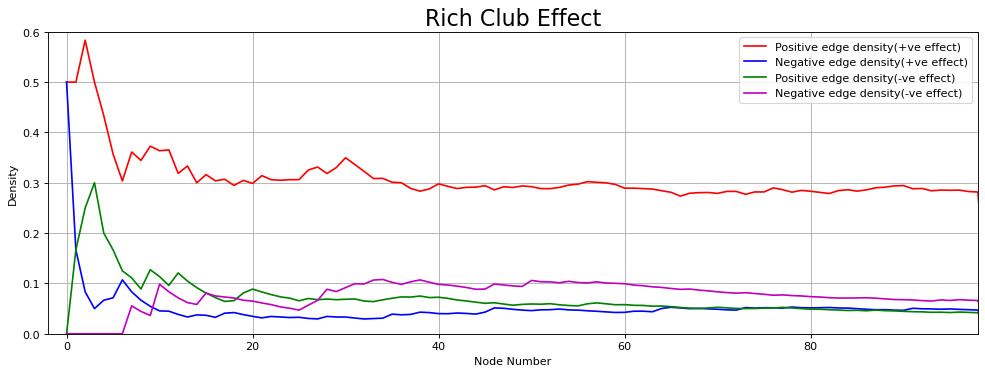

0.38847583643122674


In [28]:
richClubEffect(epi_Stats, epi_graph)

In [ ]:
def communitiesNewCode(graph):
    # compute the best partition
    partition = community_louvain.best_partition(graph)
    print(partition)
#     # draw the graph
#     pos = nx.spring_layout(graph)
#     # color the nodes according to their partition
#     cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
#     nx.draw_networkx_nodes(graph, pos, partition.keys(), node_size=40,
#                            cmap=cmap, node_color=list(partition.values()))
#     nx.draw_networkx_edges(graph, pos, alpha=0.5)
#     plt.show()

In [49]:
c1c1, c1c2  = degreeCentrality(cancer1_graph, 'BoneCancer')

Degree
('STAT1', 0.18857142857142858)
('FYN', 0.18)
('SMAD3', 0.18)
('STAT5B', 0.14285714285714285)
('ERK1', 0.14285714285714285)
('LYN', 0.13428571428571429)
('HDAC1', 0.12857142857142856)
('STAT3', 0.12571428571428572)
('CSK', 0.12285714285714286)
('SRC', 0.11714285714285715)


In [50]:
c1c3 = eigenVectorCentrality(cancer1_graph, 'BoneCancer')

Eigen Vector centrality
('STAT1', 0.2414024440213811)
('FYN', 0.23628867555131602)
('STAT5B', 0.2060086019294528)
('SRC', 0.19698116652173236)
('LYN', 0.1963108549179626)
('STAT3', 0.19618489378969584)
('CSK', 0.19523709868547479)
('GRB2', 0.18999137340030714)
('CBL', 0.18613011802077217)
('CRKL', 0.18058002800159756)


In [51]:
c1c6 = closenessCentrality(cancer1_graph, 'BoneCancer')

closeness centrality 


In [52]:
c1c7 = betweenessCentrality(cancer1_graph, 'BoneCancer')

Betweenness centrality 


In [56]:
c1c4, c1c5 = enhancedCentrality(cancer1_graph, 'BoneCancer')

19600.0


ValueError: too many values to unpack (expected 2)

In [54]:
c1c6 = khatzCentrality(cancer1_graph, 'BoneCancer')

Katz centrality


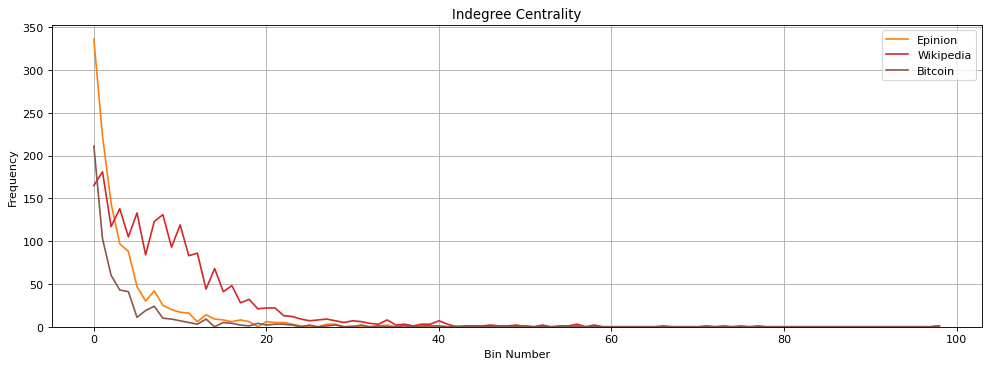

In [190]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic1['col2']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.001, max(val1), 100), visible=False)
plt.plot(n1)
val2 = wikic1['col2']
n2,x2,_2 = plt.hist(val2,bins=np.linspace(0.001, max(val2), 100), visible=False)
plt.plot(n2)
val3 = bitc1['col2']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.002, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Indegree Centrality')
plt.legend(['Epinion', 'Wikipedia', 'Bitcoin'])
plt.grid()
plt.show()

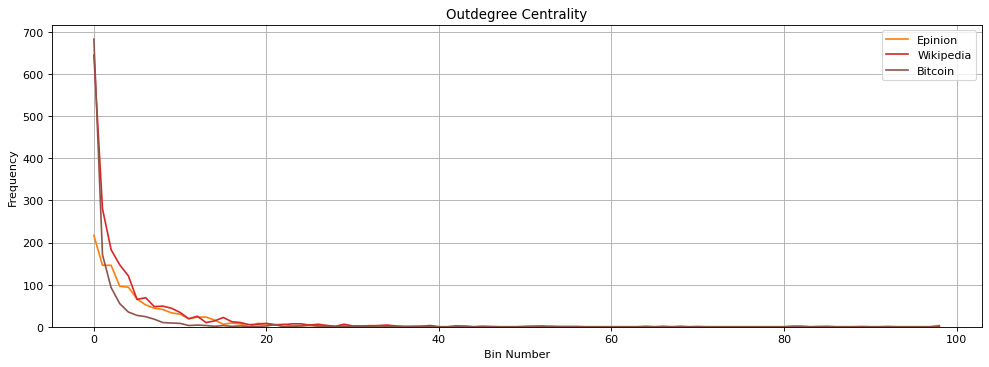

In [189]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic2['col2']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.001, max(val1), 100), visible=False)
plt.plot(n1)
val2 = wikic2['col2']
n2,x2,_2 = plt.hist(val2,bins=np.linspace(0.001, max(val2), 100), visible=False)
plt.plot(n2)
val3 = bitc2['col2']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.001, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Outdegree Centrality')
plt.legend(['Epinion', 'Wikipedia', 'Bitcoin'])
plt.grid()
plt.show()

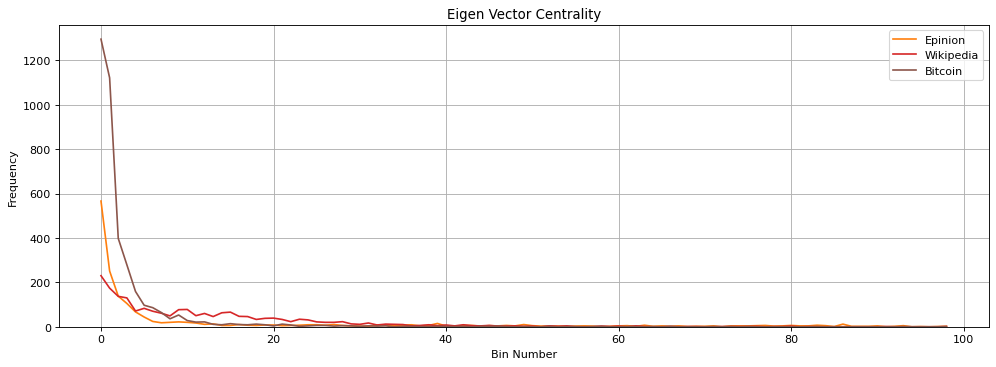

In [188]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic3['col2']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.001, max(val1), 100), visible=False)
plt.plot(n1)
val2 = wikic3['col2']
n2,x2,_2 = plt.hist(val2,bins=np.linspace(0.001, max(val2), 100), visible=False)
plt.plot(n2)
val3 = bitc3['col2']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.001, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Eigen Vector Centrality')
plt.legend(['Epinion', 'Wikipedia', 'Bitcoin'])
plt.grid()
plt.show()

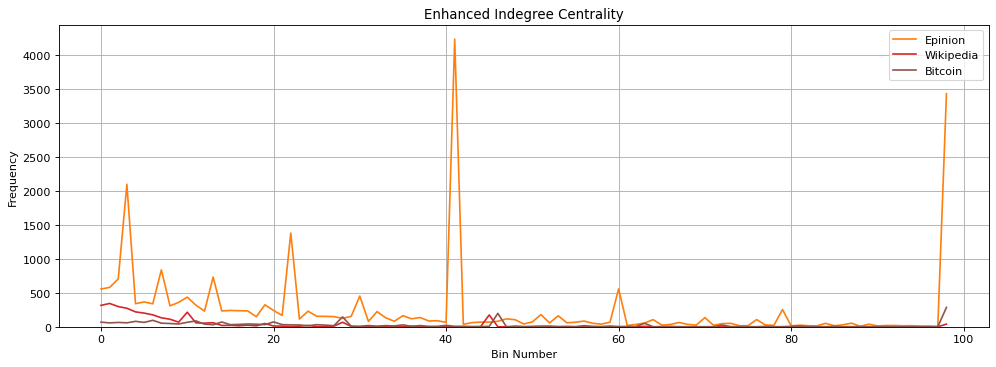

In [187]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic4['col1']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.000001, max(val1), 100), visible=False)
plt.plot(n1)
val2 = wikic4['col1']
n2,x2,_2 = plt.hist(val2,bins=np.linspace(0.00001, max(val2), 100), visible=False)
plt.plot(n2)
val3 = bitc4['col1']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.00001, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Enhanced Indegree Centrality')
plt.legend(['Epinion', 'Wikipedia', 'Bitcoin'])
plt.grid()
plt.show()

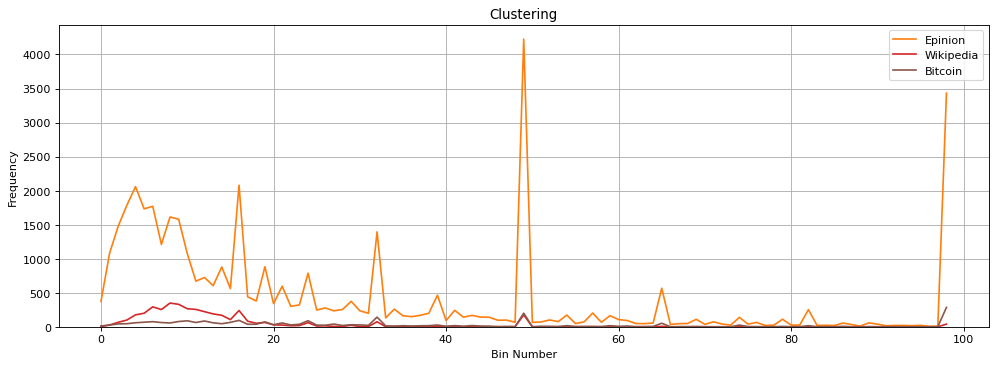

In [186]:
plt.figure(figsize=(15, 5), dpi=80)
val1 = epic5['col1']
n1,x1,_1 = plt.hist(val1,bins=np.linspace(0.001, max(val1), 100), visible=False)
plt.plot(n1)
val2 = wikic5['col1']
n2,x2,_2 = plt.hist(val2,bins=np.linspace(0.001, max(val2), 100), visible=False)
plt.plot(n2)
val3 = bitc5['col1']
n3,x3,_3 = plt.hist(val3,bins=np.linspace(0.001, max(val3), 100), visible=False)
plt.plot(n3)

plt.xlabel('Bin Number')
plt.ylabel('Frequency')
plt.title('Clustering')
plt.legend(['Epinion', 'Wikipedia', 'Bitcoin'])
plt.grid()
plt.show()

In [62]:
c1_weak_graph = weakConnected(cancer1_graph)

NetworkXNotImplemented: not implemented for undirected type

Fitted power-law distribution on discrete data

Exponent (alpha)  = 2.597631
Cutoff (xmin)     = 9.000000

Log-likelihood    = -495.199266

H0: data was drawn from the fitted distribution

KS test statistic = 0.055091
p-value           = 0.752790

H0 could not be rejected at significance level 0.05


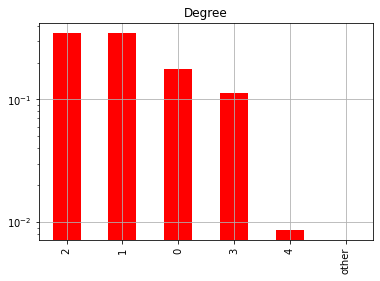

In [63]:
powerLaw(cancer1_Stats, cancer1_graph)

In [ ]:
communities(graph)

Size of maximal strongly connected component is 41441
Size of maximal weakly connected component is 119130
29732 37682 10275
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,

In [ ]:
closenessCentrality(graph)

closeness centrality 


https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.richclub.rich_club_coefficient.html#networkx.algorithms.richclub.rich_club_coefficient

In [2]:
# slice dataset into 4 UD graphs

https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.edge_subgraph.html#:~:text=Returns%20the%20subgraph%20induced%20by,any%20one%20of%20those%20edges.&text=An%20iterable%20of%20edges%20in%20this%20graph.

In [65]:
degreeRelationship(cancer1_Stats,cancer1_graph,'BoneCancer')

KeyError: 'Average neighbors degree'

<Figure size 400x400 with 0 Axes>

In [66]:
print(nx.average_shortest_path_length(cancer1_graph))

3.082002442002442


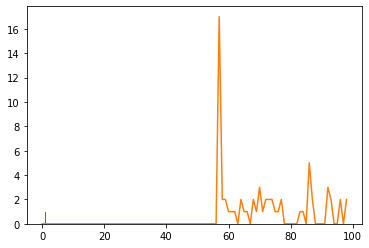

In [68]:
# ud_epi = epi_weak_graph.to_undirected()
# ud_epi.remove_edges_from(nx.selfloop_edges(ud_epi))
rc = nx.rich_club_coefficient(cancer1_graph, normalized=True, seed=10)
n1,x1,_1 = plt.hist(rc.values(),bins=np.linspace(0, max(rc.values()), 100))
plt.plot(n1)
plt.show()

In [69]:
allD = pd.read_csv('BoneCancer_ALLDATA.csv', delimiter=',')
allD

,betweenness,closeness,degree,eigenvector,khatz
0,SMAD3,STAT1,STAT1,STAT1,CDK2
1,FYN,SMAD3,FYN,FYN,CCNB1
2,HDAC1,ERK1,SMAD3,STAT5B,CCNB2
3,CTNNB1,FYN,STAT5B,SRC,FZR1
4,STAT5B,STAT5B,ERK1,LYN,CCNA2
...,...,...,...,...,...
95,NUP153,MYC,TAB2,DAXX,FOXO1A
96,AIP4,RALBP1,NCOR1,CD44,TFDP2
97,ERK2,CDK7,PPP2CA,CLTC,TIP1
98,SPRY2,PKN1,FHL2,CDK4,SNX4


In [70]:
sns.heatmap(allD)
plt.show()

ValueError: could not convert string to float: 'SMAD3'